In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.manifold import TSNE

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

### Data cleanup

In [3]:
df_median_age = df_train.groupby(['Sex', 'Pclass'])['Age'].median().reset_index()
df_median_age = df_median_age.rename(columns={'Age' : 'Median_Age'})

df_train = df_train.merge(df_median_age, on=['Sex', 'Pclass'], how='left')
df_train.loc[df_train['Age'].isna(), 'Age'] = df_train['Median_Age']
df_train = df_train.drop(columns = 'Median_Age')

df_test = df_test.merge(df_median_age, on=['Sex', 'Pclass'], how='left')
df_test.loc[df_test['Age'].isna(), 'Age'] = df_test['Median_Age']
df_test = df_test.drop(columns = 'Median_Age')

In [4]:
df_train['Cabin_Type'] = df_train.loc[df_train['Cabin'].notna()]['Cabin'].apply(lambda x: x[0])
df_test['Cabin_Type'] = df_test.loc[df_test['Cabin'].notna()]['Cabin'].apply(lambda x: x[0])

df_train['Cabin_Nos'] = df_train.loc[df_train['Cabin'].notna()]['Cabin'].apply(lambda x: len(x.split()))
df_test['Cabin_Nos'] = df_test.loc[df_test['Cabin'].notna()]['Cabin'].apply(lambda x: len(x.split()))

df_train = df_train.drop(columns='Cabin')
df_test = df_test.drop(columns='Cabin')

In [5]:
new_df_train = pd.get_dummies(df_train['Sex'])
df_train = pd.concat([df_train, new_df_train], axis=1)

new_df_test = pd.get_dummies(df_test['Sex'])
df_test = pd.concat([df_test, new_df_test], axis=1)

df_train = df_train.drop(columns=['Sex'])
df_test = df_test.drop(columns=['Sex'])

In [6]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')
df_test['Embarked'] = df_test['Embarked'].fillna('S')

new_df_train = pd.get_dummies(df_train['Embarked'])
new_cols = ['Embarked_{}'.format(x) for x in new_df_train.columns.values]
new_df_train.columns = new_cols
df_train = pd.concat([df_train, new_df_train], axis=1)

new_df_test = pd.get_dummies(df_test['Embarked'])
new_cols = ['Embarked_{}'.format(x) for x in new_df_test.columns.values]
new_df_test.columns = new_cols
df_test = pd.concat([df_test, new_df_test], axis=1)

df_train = df_train.drop(columns=['Embarked'])
df_test = df_test.drop(columns=['Embarked'])

In [7]:
new_df_train = pd.get_dummies(df_train['Cabin_Type'])
new_cols = ['Cabin_Type_{}'.format(x) for x in new_df_train.columns.values]
new_df_train.columns = new_cols
df_train = pd.concat([df_train, new_df_train], axis=1)

new_df_test = pd.get_dummies(df_test['Cabin_Type'])
new_cols = ['Cabin_Type_{}'.format(x) for x in new_df_test.columns.values]
new_df_test.columns = new_cols
df_test = pd.concat([df_test, new_df_test], axis=1)

df_train = df_train.drop(columns=['Cabin_Type'])
df_test = df_test.drop(columns=['Cabin_Type'])

In [8]:
class_fare_dict = df_train.groupby('Pclass')['Fare'].median().to_dict()

df_train['Pclass_Fare_median'] = df_train['Pclass'].apply(lambda x: class_fare_dict[x])
df_test['Pclass_Fare_median'] = df_test['Pclass'].apply(lambda x: class_fare_dict[x])

df_train.loc[df_train['Fare'].isna(), 'Fare'] = df_train['Pclass_Fare_median']
df_test.loc[df_test['Fare'].isna(), 'Fare'] = df_test['Pclass_Fare_median']

df_train = df_train.drop(columns = 'Pclass_Fare_median')
df_test = df_test.drop(columns = 'Pclass_Fare_median')

In [9]:
new_df_train = pd.get_dummies(df_train['Pclass'])
new_cols = ['Pclass_{}'.format(x) for x in new_df_train.columns.values]
new_df_train.columns = new_cols
df_train = pd.concat([df_train, new_df_train], axis=1)

new_df_test = pd.get_dummies(df_test['Pclass'])
new_cols = ['Pclass_{}'.format(x) for x in new_df_test.columns.values]
new_df_test.columns = new_cols
df_test = pd.concat([df_test, new_df_test], axis=1)

df_train = df_train.drop(columns=['Pclass'])
df_test = df_test.drop(columns=['Pclass'])

In [10]:
df_train['Cabin_Nos'] = df_train['Cabin_Nos'].fillna(1)
df_test['Cabin_Nos'] = df_test['Cabin_Nos'].fillna(1)

In [11]:
df_test['Cabin_Type_T'] = 0

In [12]:
inp_col_list = list(df_train.columns.values)
inp_col_list.remove('PassengerId')
inp_col_list.remove('Survived')
inp_col_list.remove('Name')
inp_col_list.remove('Ticket')
# inp_col_list.remove('Age')

inp_col_list.remove('Pclass_1')
inp_col_list.remove('Pclass_2')
inp_col_list.remove('Pclass_3')

inp_col_list.remove('Cabin_Type_A')
inp_col_list.remove('Cabin_Type_B')
inp_col_list.remove('Cabin_Type_C')
inp_col_list.remove('Cabin_Type_D')
inp_col_list.remove('Cabin_Type_E')
inp_col_list.remove('Cabin_Type_F')
inp_col_list.remove('Cabin_Type_G')
inp_col_list.remove('Cabin_Type_T')

inp_col_list.remove('Embarked_C')
inp_col_list.remove('Embarked_Q')
inp_col_list.remove('Embarked_S')

inp_col_list.remove('Parch')

inp_col_list.remove('Cabin_Nos')

In [13]:
X = df_train[inp_col_list]
Y = df_train['Survived']

x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=0)

In [14]:
etc = ExtraTreesClassifier(criterion = 'entropy', max_depth = 7, min_samples_leaf = 5, max_features = None, min_impurity_decrease = 1e-3, random_state = 42)
etc.fit(x_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=7, max_features=None,
                     min_impurity_decrease=0.001, min_samples_leaf=5,
                     random_state=42)

In [15]:
score = etc.score(x_test, y_test)
print(score)

0.8044692737430168


In [16]:
leaves = etc.apply(x_train)

In [19]:
M = OneHotEncoder().fit_transform(leaves)

In [21]:
S = (M*M.transpose()).todense()

In [23]:
D = 1 - S/S.max()

In [27]:
embed = TSNE(metric='precomputed', perplexity=30).fit_transform(D)

/home/madhav/anaconda3/envs/kgl_titanic/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/madhav/anaconda3/envs/kgl_titanic/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/madhav/anaconda3/envs/kgl_titanic/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
/home/madhav/anaconda3/envs/kgl_titanic/lib/python3.10/site-packages/sklearn/utils/validation.

<AxesSubplot:xlabel='0', ylabel='1'>

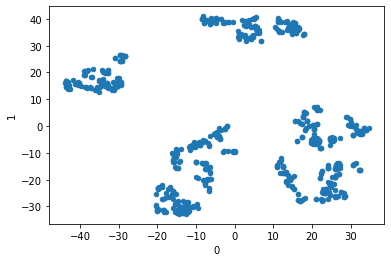

In [31]:
pd.DataFrame(embed).plot.scatter(x=0,y=1)

In [41]:
X = df_test[inp_col_list]
x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled)

In [42]:
predictions = etc.predict(X_scaled)

In [43]:
df_test['Survived'] = predictions

In [44]:
df_test[['PassengerId', 'Survived']].to_csv('../submissions/extra_trees_2_submission.csv', index=False)